In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import sys

ROOT_DIR = '/content/drive/MyDrive/Data/DataScience_Project' 
## Change ROOT_DIR to your working directory.
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
ID = "id"
TARGET = "site_eui"

TEST_SIZE = 0.2
seed = 42

In [ ]:
train=pd.read_csv("./train.csv.zip", compression='zip')
test=pd.read_csv("./test.csv.zip", compression='zip')

In [ ]:
train[train.columns[train.isna().sum()!=0]].isna().sum()/train.shape[0]

year_built                   0.024249
energy_star_rating           0.352561
direction_max_wind_speed     0.542287
direction_peak_wind_speed    0.551909
max_wind_speed               0.542287
days_with_fog                0.604512
dtype: float64

Correlation of Site EUI with other features

In [ ]:
import seaborn as sns

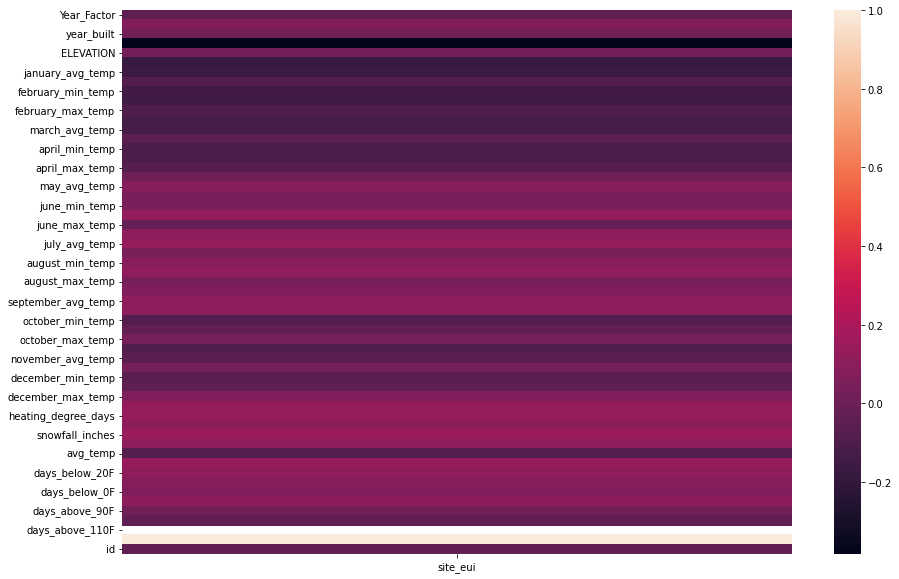

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(pd.DataFrame(train.corr()['site_eui']))
fig = ax.get_figure()

Handling NaN values

In [ ]:
cols_to_drop = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
train.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
train.dropna(subset=['year_built'], inplace=True)

In [ ]:
train.fillna({"energy_star_rating": train['energy_star_rating'].mean()}, inplace=True)

Making the table of statistics for site EUI values for different types of facillities.

In [ ]:
d = []
for i in train['facility_type'].unique():
    t = []
    t.append(i)
    t.append(train[train['facility_type'] == i]['site_eui'].mean())
    t.append(train[train['facility_type'] == i]['site_eui'].std())
    t.append(train[train['facility_type'] == i]['site_eui'].max())
    t.append(train[train['facility_type'] == i]['site_eui'].min())
    d.append(t)

In [ ]:
df = pd.DataFrame(d, columns = ['Facility Type', 'mean site_eui', 'standard deviation site_eui', 'max site_eui', 'min site_eui'])

In [ ]:
df = df.round(decimals = 3)

In [ ]:
df = df.sort_values(by=['mean site_eui'], ascending=False).reset_index(drop=True)

In [ ]:
df.to_csv('facility_type_and_eui_values.csv')

Making plots for site EUI values against year for different facility types

In [ ]:
facility = df['Facility Type'].unique()

In [ ]:
data = train[train['facility_type'] == 'Data_Center']

Text(0.08, 0.5, 'Site EUI values')

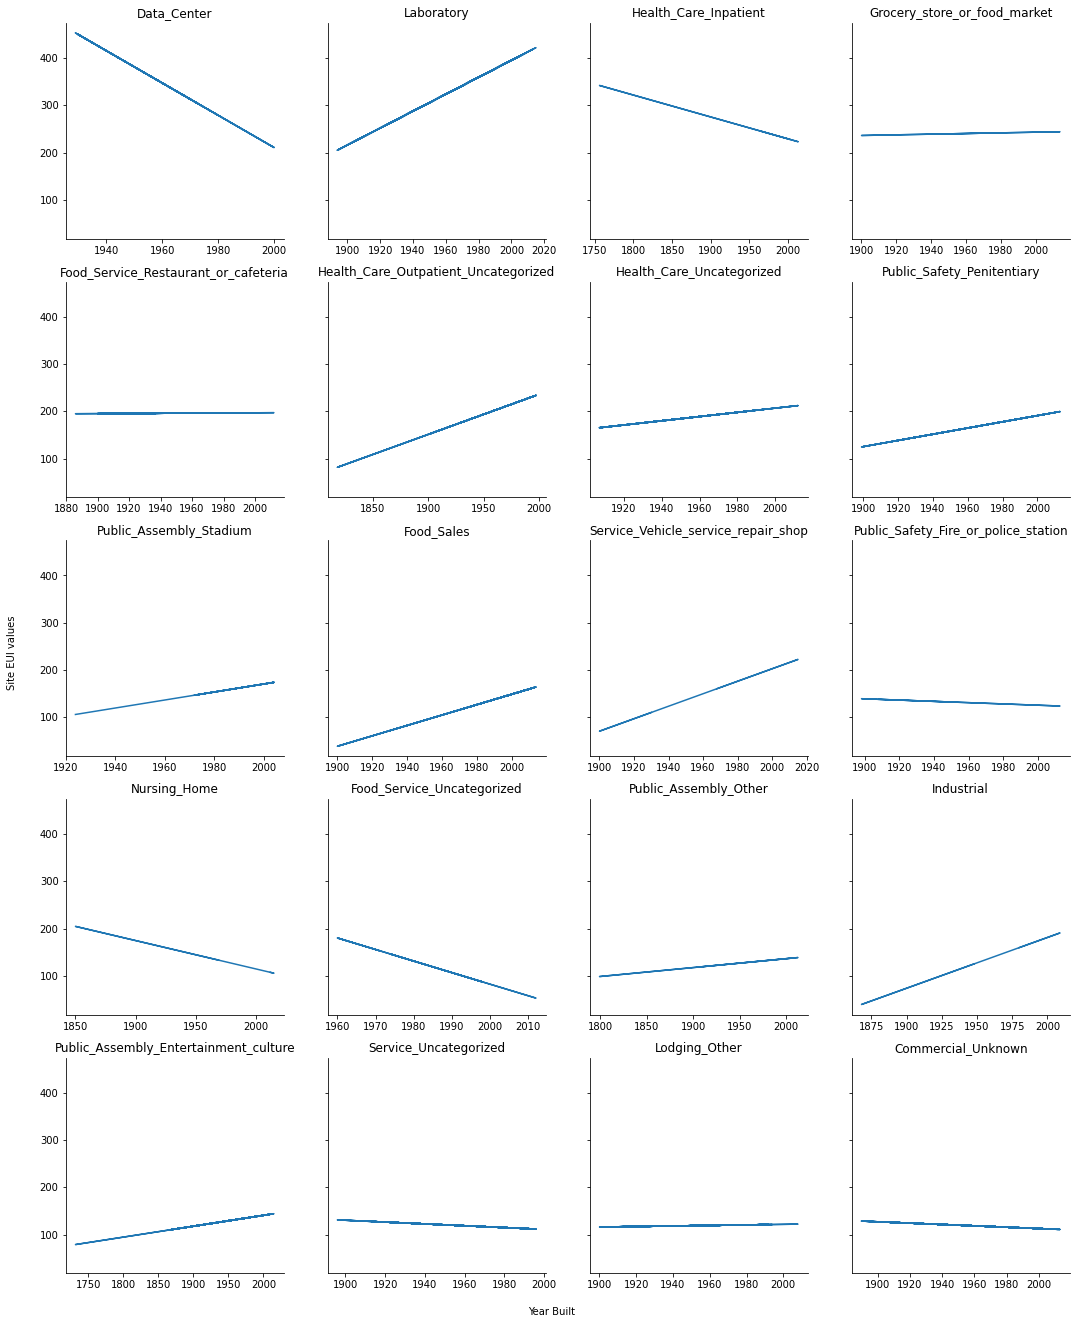

In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize=(18,23), sharey=True)

for r in range(5):
    for c in range(4):
        data = train[train['facility_type'] == facility[4*r + c]]
        a, b = np.polyfit(data['year_built'], data['site_eui'], 1)
        ax[r,c].plot(data['year_built'], a*data['year_built']+b)
        ax[r,c].set_title(facility[4*r + c])
        sns.despine()
fig.text(0.5, 0.1, 'Year Built', ha='center')
fig.text(0.08, 0.5, 'Site EUI values', va='center', rotation='vertical')

In [ ]:
fig.savefig('facility_type_vs_time.png')

One Hot Encoding

In [ ]:
scaler = StandardScaler()
train_one_hot = pd.get_dummies(train)
X = train_one_hot.drop([ID,TARGET],axis = 1)
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y = train_one_hot[TARGET]

X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X, y, test_size=TEST_SIZE, random_state=seed)

Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

train_copy = train.copy()
test_copy = test.copy()

#preprocess
str_list = [] 
num_list = []
for colname, colvalue in train_copy.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)
        
for col in str_list:
    encoder = LabelEncoder()
    encoder.fit(train_copy[col])
    train_copy[col] = encoder.transform(train_copy[col])

    for label in np.unique(test_copy[col]):
        if label not in encoder.classes_: 
            encoder.classes_ = np.append(encoder.classes_, label) 
    test_copy[col] = encoder.transform(test_copy[col])

train_one_hot = pd.get_dummies(train_copy)
X = train_one_hot.drop([ID,TARGET],axis = 1)
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y = train_one_hot[TARGET]

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=TEST_SIZE, random_state=seed)

PCA after one-hot encoding

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
train_one_hot = pd.get_dummies(train)
X = train_one_hot.drop([ID,TARGET],axis = 1)
y = train_one_hot[TARGET]
pca = PCA(n_components = 64)
X_pca = pd.DataFrame(pca.fit_transform(X))
scaler = StandardScaler()
X_pca = pd.DataFrame(scaler.fit_transform(X_pca), columns = X_pca.columns)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=TEST_SIZE, random_state=seed)

# Linear Regression

#### Simple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

One Hot Encoding

In [ ]:
model = LinearRegression()
model.fit(X_train_onehot,y_train_onehot)

LinearRegression()

In [ ]:
pred_test=model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

47.14199198736851 24.152892529446408 0.35104074152259435


One hot with PCA

In [ ]:
model = LinearRegression()
model.fit(X_train_pca,y_train_pca)

LinearRegression()

In [ ]:
pred_test=model.predict(X_test_pca)
rmse=mean_squared_error(y_test_pca, pred_test, squared=False)
mae=mean_absolute_error(y_test_pca, pred_test)
r2 = r2_score(y_test_pca, pred_test)
print(rmse, mae, r2)

51.729531577992226 26.709400790226 0.21859053949765161


Label Encoding

In [ ]:
model = LinearRegression()
model.fit(X_train_label,y_train_label)

LinearRegression()

In [ ]:
pred_test=model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

52.26360190078295 27.58020757021538 0.2023722636254044


#### Lasso Regression

One hot Encoding

In [ ]:
from sklearn import linear_model
model = linear_model.LassoLars(alpha=.1, normalize=True)
model.fit(X_train_onehot,y_train_onehot)

LassoLars(alpha=0.1, normalize=True)

In [ ]:
pred_test=model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

58.519484768579424 33.85447378679252 -5.8965146387812695e-06


Label Encoder

In [ ]:
from sklearn import linear_model
model = linear_model.LassoLars(alpha=.1, normalize=True)
model.fit(X_train_label,y_train_label)

LassoLars(alpha=0.1, normalize=True)

In [ ]:
pred_test=model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

58.519484768579424 33.85447378679252 -5.8965146387812695e-06


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

One Hot Encoding

In [ ]:
model = RandomForestRegressor(max_depth=12, random_state=0)
model.fit(X_train_onehot, y_train_onehot)

RandomForestRegressor(max_depth=12, random_state=0)

In [ ]:
pred_test=model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

41.69917868703175 22.250183653635506 0.4673135113208743


Label Encoding

In [ ]:
model = RandomForestRegressor(max_depth=12, random_state=0)
model.fit(X_train_label,y_train_label)

RandomForestRegressor(max_depth=12, random_state=0)

In [ ]:
pred_test=model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

41.39066569852594 21.367239819315305 0.4751665561623074


# Neural network

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import regularizers
tf.random.set_seed(seed)

## Normal MLP

One Hot Encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])
model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.build(input_shape=X_train_onehot.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (60605, 1024)             132096    
                                                                 
 dropout (Dropout)           (60605, 1024)             0         
                                                                 
 dense_1 (Dense)             (60605, 512)              524800    
                                                                 
 dropout_1 (Dropout)         (60605, 512)              0         
                                                                 
 dense_2 (Dense)             (60605, 256)              131328    
                                                                 
 dropout_2 (Dropout)         (60605, 256)              0         
                                                                 
 dense_3 (Dense)             (60605, 128)              3

In [ ]:
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 21s 10ms/step - loss: 2757.5037 - root_mean_squared_error: 52.5119
Epoch 2/30
1894/1894 [==============================] - 15s 8ms/step - loss: 2537.8037 - root_mean_squared_error: 50.3766
Epoch 3/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2476.5046 - root_mean_squared_error: 49.7645
Epoch 4/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2444.3594 - root_mean_squared_error: 49.4405
Epoch 5/30
1894/1894 [==============================] - 11s 6ms/step - loss: 2417.5015 - root_mean_squared_error: 49.1681
Epoch 6/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2307.7178 - root_mean_squared_error: 48.0387
Epoch 7/30
1894/1894 [==============================] - 11s 6ms/step - loss: 2295.0408 - root_mean_squared_error: 47.9066
Epoch 8/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2265.6445 - root_mean_squared_error: 47.5988
Epoch 9/30
1894/1894 [=

In [ ]:
pred_test = model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

46.56369683477466 22.94036580267656 0.3668647709811341


Label Encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 12s 6ms/step - loss: 3216.9893 - root_mean_squared_error: 56.7185
Epoch 2/30
1894/1894 [==============================] - 10s 5ms/step - loss: 3016.3726 - root_mean_squared_error: 54.9215
Epoch 3/30
1894/1894 [==============================] - 11s 6ms/step - loss: 2928.0457 - root_mean_squared_error: 54.1114
Epoch 4/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2908.9155 - root_mean_squared_error: 53.9344
Epoch 5/30
1894/1894 [==============================] - 11s 6ms/step - loss: 2866.9812 - root_mean_squared_error: 53.5442
Epoch 6/30
1894/1894 [==============================] - 10s 5ms/step - loss: 2763.6416 - root_mean_squared_error: 52.5704
Epoch 7/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2730.5447 - root_mean_squared_error: 52.2546
Epoch 8/30
1894/1894 [==============================] - 10s 6ms/step - loss: 2708.3943 - root_mean_squared_error: 52.0422
Epoch 9/30
1894/1894 [==

In [ ]:
pred_test=model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

51.451592010414686 24.97385426851281 0.22696491062481117


## With L2 Regularization

One Hot Encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = regularizers.L2(1e-1))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 14s 6ms/step - loss: 2880.8643 - root_mean_squared_error: 52.7037
Epoch 2/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2637.9341 - root_mean_squared_error: 50.6172
Epoch 3/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2547.1187 - root_mean_squared_error: 49.8037
Epoch 4/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2522.4695 - root_mean_squared_error: 49.5914
Epoch 5/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2457.9380 - root_mean_squared_error: 48.9377
Epoch 6/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2404.9182 - root_mean_squared_error: 48.3638
Epoch 7/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2381.1531 - root_mean_squared_error: 48.0948
Epoch 8/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2357.1265 - root_mean_squared_error: 47.8087
Epoch 9/30
1894/1894 [==

In [ ]:
pred_test = model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

45.705044579841385 22.832991049983196 0.3899999830481182


Label Encoding

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = regularizers.L2(1e-1))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 13s 6ms/step - loss: 3260.8123 - root_mean_squared_error: 56.3019
Epoch 2/30
1894/1894 [==============================] - 12s 6ms/step - loss: 3017.3103 - root_mean_squared_error: 54.3503
Epoch 3/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2933.8738 - root_mean_squared_error: 53.6654
Epoch 4/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2915.1885 - root_mean_squared_error: 53.5322
Epoch 5/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2825.4548 - root_mean_squared_error: 52.6941
Epoch 6/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2751.6726 - root_mean_squared_error: 51.9489
Epoch 7/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2727.9714 - root_mean_squared_error: 51.7007
Epoch 8/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2707.9954 - root_mean_squared_error: 51.4799
Epoch 9/30
1894/1894 [==

In [ ]:
pred_test=model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

49.00744971588863 24.424276684304065 0.29866456972025424


## L1 regularization

One Hot Encoding

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="relu", kernel_regularizer = regularizers.L1(0.4))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 13s 6ms/step - loss: 4145.1104 - root_mean_squared_error: 52.3787
Epoch 2/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2933.1692 - root_mean_squared_error: 49.9541
Epoch 3/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2771.5410 - root_mean_squared_error: 49.2370
Epoch 4/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2694.9512 - root_mean_squared_error: 48.9225
Epoch 5/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2679.2078 - root_mean_squared_error: 48.9943
Epoch 6/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2619.5579 - root_mean_squared_error: 48.5286
Epoch 7/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2594.7905 - root_mean_squared_error: 48.3709
Epoch 8/30
1894/1894 [==============================] - 12s 6ms/step - loss: 2570.4653 - root_mean_squared_error: 48.1846
Epoch 9/30
1894/1894 [==

In [ ]:
pred_test = model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

46.83151240734012 22.933216578960877 0.3595607502211985


Label Encoding

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="relu", kernel_regularizer = regularizers.L1(0.4))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1894/1894 [==============================] - 12s 6ms/step - loss: 4206.5078 - root_mean_squared_error: 56.7508
Epoch 2/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3288.0364 - root_mean_squared_error: 54.4247
Epoch 3/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3151.9365 - root_mean_squared_error: 53.6346
Epoch 4/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3116.4028 - root_mean_squared_error: 53.5418
Epoch 5/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3089.2998 - root_mean_squared_error: 53.3753
Epoch 6/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3022.6228 - root_mean_squared_error: 52.8399
Epoch 7/30
1894/1894 [==============================] - 11s 6ms/step - loss: 2997.0889 - root_mean_squared_error: 52.6747
Epoch 8/30
1894/1894 [==============================] - 11s 6ms/step - loss: 3005.7046 - root_mean_squared_error: 52.7925
Epoch 9/30
1894/1894 [==

In [ ]:
pred_test = model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

49.91789560563073 24.82533169631051 0.2723641131468235


# CatBoost Model

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
import random,os
from catboost import CatBoostRegressor

ID = "id"
TARGET = "site_eui"

TEST_SIZE = 0.2

SEED = 2022
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

MODEL_MAX_DEPTH = 12
MODEL_TASK_TYPE = 'GPU'
MODEL_RL = 0.025
MODEL_EVAL_METRIC ='RMSE'
MODEL_LOSS_FUNCTION = 'RMSE'
MODEL_ESR = 10
MODEL_VERBOSE = 500
MODEL_ITERATIONS = 5000

One-hot encoding

In [ ]:
model = CatBoostRegressor(
    verbose=MODEL_VERBOSE,
    early_stopping_rounds=MODEL_ESR,
    random_seed=SEED,
    max_depth=MODEL_MAX_DEPTH,
    task_type=MODEL_TASK_TYPE,
    learning_rate=MODEL_RL,
    iterations=MODEL_ITERATIONS,
    loss_function=MODEL_LOSS_FUNCTION,
    eval_metric= MODEL_EVAL_METRIC,
    train_dir = "/content/drive/MyDrive/DataScience_Project"
)
history = model.fit(X_train_onehot, y_train_onehot)

0:	learn: 57.5512523	total: 44.7ms	remaining: 3m 43s
500:	learn: 36.8435509	total: 15.2s	remaining: 2m 16s
1000:	learn: 33.1185059	total: 30.4s	remaining: 2m 1s
1500:	learn: 30.6848353	total: 45.7s	remaining: 1m 46s
2000:	learn: 28.7818734	total: 1m 1s	remaining: 1m 31s
2500:	learn: 27.2905629	total: 1m 16s	remaining: 1m 16s
3000:	learn: 25.9871503	total: 1m 31s	remaining: 1m 1s
3500:	learn: 24.8502387	total: 1m 47s	remaining: 45.9s
4000:	learn: 23.8419146	total: 2m 2s	remaining: 30.6s
4500:	learn: 22.9466475	total: 2m 18s	remaining: 15.3s
4999:	learn: 22.1464978	total: 2m 33s	remaining: 0us


In [ ]:
pred_test = model.predict(X_test_onehot)
rmse=mean_squared_error(y_test_onehot, pred_test, squared=False)
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

39.044766770754514 19.9892275431432 0.532972617176212


Label Encoding

In [ ]:
model = CatBoostRegressor(
    verbose=MODEL_VERBOSE,
    early_stopping_rounds=MODEL_ESR,
    random_seed=SEED,
    max_depth=MODEL_MAX_DEPTH,
    task_type=MODEL_TASK_TYPE,
    learning_rate=MODEL_RL,
    iterations=MODEL_ITERATIONS,
    loss_function=MODEL_LOSS_FUNCTION,
    eval_metric= MODEL_EVAL_METRIC
)
model.fit(X_train_label, y_train_label)

0:	learn: 57.7017027	total: 259ms	remaining: 21m 34s
500:	learn: 37.6057785	total: 2m 40s	remaining: 24m 2s
1000:	learn: 33.5222307	total: 4m 56s	remaining: 19m 44s
1500:	learn: 30.9705380	total: 7m 20s	remaining: 17m 8s
2000:	learn: 29.0965541	total: 9m 38s	remaining: 14m 27s
2500:	learn: 27.6301989	total: 12m 1s	remaining: 12m 1s
3000:	learn: 26.3600792	total: 14m 14s	remaining: 9m 29s
3500:	learn: 25.2295085	total: 16m 26s	remaining: 7m 2s
4000:	learn: 24.2366516	total: 18m 37s	remaining: 4m 38s
4500:	learn: 23.4065605	total: 20m 47s	remaining: 2m 18s
4999:	learn: 22.6209190	total: 22m 55s	remaining: 0us


In [ ]:
pred_test = model.predict(X_test_label)
rmse=mean_squared_error(y_test_label, pred_test, squared=False)
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

39.47028093629372 19.938065777700942 0.5450726905600345
